# Convolutional Neural Networks: Understanding Inductive Bias
## A Deep Dive into Architectural Design Choices

**Author:** Miguel Vanegas  
**Date:** 2026-02-10  
**Course:** Neural Networks - AI Bootcamp Workshop

---

## Context and Motivation

Neural networks are not black boxes. Every architectural decision introduces assumptions about the structure of the data—this is called **inductive bias**.

In this notebook, we explore:
- **Why convolutional layers work** for image-like data
- **How design choices** (kernel size, depth, stride, padding) affect learning
- **When convolution is appropriate** (and when it's not)

Rather than following a recipe, we will:
1. Select and analyze a dataset
2. Build a baseline without convolutions
3. Design a convolutional architecture from scratch
4. Conduct controlled experiments
5. Interpret the results through the lens of inductive bias

## 1. Dataset Selection and Justification

### Chosen Dataset: CIFAR-10

**Source:** [PyTorch torchvision.datasets](https://pytorch.org/vision/stable/datasets.html#cifar)  
**Type:** Color images (32×32×3)  
**Classes:** 10 (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck)  
**Size:** 50,000 training images, 10,000 test images

### Why CIFAR-10 is appropriate for convolutional layers:

1. **Spatial Structure:** Images have local patterns (edges, textures) that benefit from local receptive fields
2. **Translation Invariance:** Objects can appear anywhere in the image → weight sharing is beneficial
3. **Hierarchical Features:** Low-level features (edges) combine into high-level features (shapes, objects)
4. **Computational Constraints:** Small enough to train on a laptop, large enough to be non-trivial
5. **Complexity:** More challenging than MNIST (color, more classes, real-world objects)

### Alternative Consideration:
MNIST would be too simple. CIFAR-10 requires the network to learn meaningful spatial hierarchies, making it ideal for studying convolutional inductive bias.

In [23]:
%pip install torch torchvision matplotlib numpy seaborn pandas

Note: you may need to restart the kernel to use updated packages.


failed to locate pyvenv.cfg: El sistema no puede encontrar el archivo especificado.




In [4]:
# Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
import seaborn as sns
from collections import Counter

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## 2. Dataset Exploration (EDA)

Before designing any architecture, we must understand the data structure.

In [5]:
# Load CIFAR-10 dataset (without normalization for EDA)
transform_eda = transforms.Compose([
    transforms.ToTensor()
])

trainset_eda = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform_eda)
testset_eda = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform_eda)

# Class names
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

print(f"Training set size: {len(trainset_eda)}")
print(f"Test set size: {len(testset_eda)}")
print(f"Number of classes: {len(classes)}")
print(f"Classes: {classes}")

100.0%
c:\Users\migue\Desktop\Universidad\TDSE\NeuralNetworks\.venv\Lib\site-packages\torchvision\datasets\cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


Training set size: 50000
Test set size: 10000
Number of classes: 10
Classes: ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


### 2.1 Image Dimensions and Channels

In [6]:
# Inspect a single image
sample_image, sample_label = trainset_eda[0]
print(f"Image shape: {sample_image.shape}")  # (C, H, W)
print(f"Channels: {sample_image.shape[0]}")
print(f"Height: {sample_image.shape[1]}")
print(f"Width: {sample_image.shape[2]}")
print(f"Data type: {sample_image.dtype}")
print(f"Value range: [{sample_image.min():.3f}, {sample_image.max():.3f}]")

Image shape: torch.Size([3, 32, 32])
Channels: 3
Height: 32
Width: 32
Data type: torch.float32
Value range: [0.000, 1.000]


### 2.2 Class Distribution

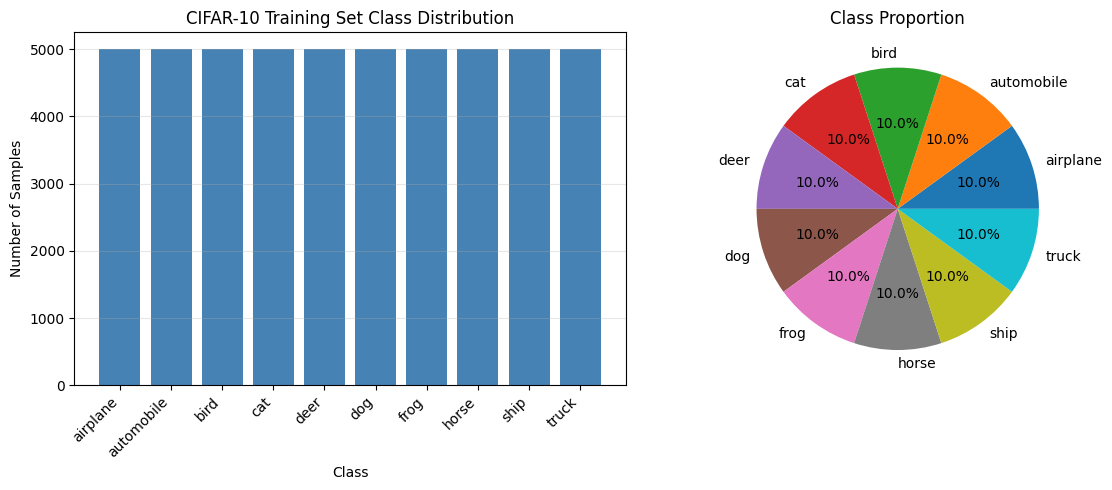


Class Distribution:
    airplane:  5000 samples (10.0%)
  automobile:  5000 samples (10.0%)
        bird:  5000 samples (10.0%)
         cat:  5000 samples (10.0%)
        deer:  5000 samples (10.0%)
         dog:  5000 samples (10.0%)
        frog:  5000 samples (10.0%)
       horse:  5000 samples (10.0%)
        ship:  5000 samples (10.0%)
       truck:  5000 samples (10.0%)


In [7]:
# Count samples per class
train_labels = [label for _, label in trainset_eda]
label_counts = Counter(train_labels)

# Visualize distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(classes, [label_counts[i] for i in range(10)], color='steelblue')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('CIFAR-10 Training Set Class Distribution')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

plt.subplot(1, 2, 2)
plt.pie([label_counts[i] for i in range(10)], labels=classes, autopct='%1.1f%%')
plt.title('Class Proportion')

plt.tight_layout()
plt.show()

print("\nClass Distribution:")
for i, cls in enumerate(classes):
    print(f"{cls:>12}: {label_counts[i]:5d} samples ({label_counts[i]/len(trainset_eda)*100:.1f}%)")

**Observation:** CIFAR-10 is perfectly balanced—each class has exactly 5,000 samples. No class imbalance handling needed.

### 2.3 Sample Visualization

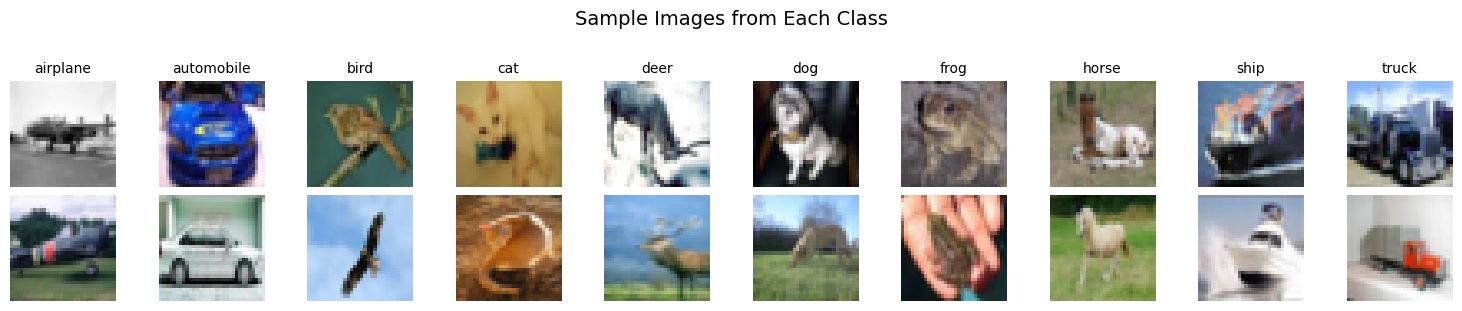

In [8]:
# Display 20 random samples (2 per class)
fig, axes = plt.subplots(2, 10, figsize=(15, 3))
fig.suptitle('Sample Images from Each Class', fontsize=14, y=1.02)

for i in range(10):
    # Find indices for this class
    class_indices = [idx for idx, (_, label) in enumerate(trainset_eda) if label == i]
    
    # Select 2 random samples
    samples = np.random.choice(class_indices, 2, replace=False)
    
    for j, idx in enumerate(samples):
        img, _ = trainset_eda[idx]
        # Convert from (C, H, W) to (H, W, C) for matplotlib
        img = img.permute(1, 2, 0).numpy()
        
        axes[j, i].imshow(img)
        axes[j, i].axis('off')
        if j == 0:
            axes[j, i].set_title(classes[i], fontsize=10)

plt.tight_layout()
plt.show()

**Observations:**
- Images are low resolution (32×32)
- Objects vary in position, scale, and orientation
- Background clutter is present
- Some classes are visually similar (e.g., cat vs. dog)

These properties make CIFAR-10 challenging and suitable for testing convolutional inductive bias.

### 2.4 Pixel Intensity Statistics

All images tensor shape: torch.Size([50000, 3, 32, 32])

Per-channel statistics (RGB):
Mean: tensor([0.4914, 0.4822, 0.4465])
Std:  tensor([0.2470, 0.2435, 0.2616])


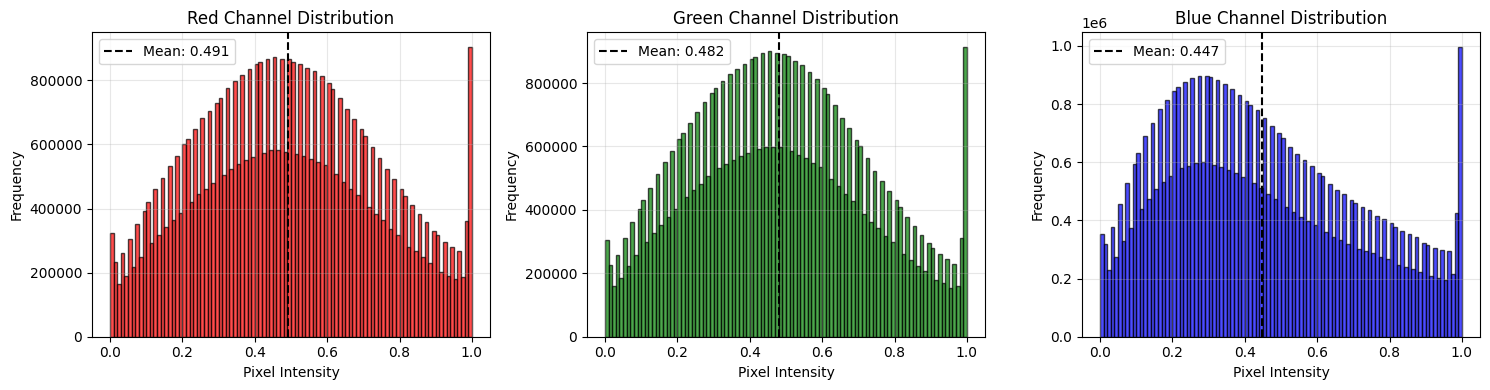

In [9]:
# Compute mean and std per channel
# Stack all training images
all_images = torch.stack([img for img, _ in trainset_eda])
print(f"All images tensor shape: {all_images.shape}")  # (50000, 3, 32, 32)

# Compute statistics per channel
mean = all_images.mean(dim=[0, 2, 3])  # Mean across batch, height, width
std = all_images.std(dim=[0, 2, 3])

print(f"\nPer-channel statistics (RGB):")
print(f"Mean: {mean}")
print(f"Std:  {std}")

# Visualize intensity distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
colors = ['red', 'green', 'blue']
channel_names = ['Red', 'Green', 'Blue']

for i in range(3):
    channel_data = all_images[:, i, :, :].flatten().numpy()
    axes[i].hist(channel_data, bins=100, color=colors[i], alpha=0.7, edgecolor='black')
    axes[i].set_title(f'{channel_names[i]} Channel Distribution')
    axes[i].set_xlabel('Pixel Intensity')
    axes[i].set_ylabel('Frequency')
    axes[i].axvline(mean[i], color='black', linestyle='--', label=f'Mean: {mean[i]:.3f}')
    axes[i].legend()
    axes[i].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### 2.5 Preprocessing Decision

Based on the EDA, we will apply:

1. **Normalization:** Standardize each channel using computed mean/std
2. **Data Augmentation (training only):**
   - Random horizontal flip
   - Random crop with padding
   
**Justification:** Normalization helps gradient flow. Augmentation introduces translation/flip invariance, which aligns with the convolutional inductive bias we want to test.

In [10]:
# Define transforms for training and testing
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Load final datasets
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                       download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                      download=True, transform=transform_test)

# Create data loaders
batch_size = 128
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Training batches: {len(trainloader)}")
print(f"Test batches: {len(testloader)}")

Training batches: 391
Test batches: 79


---

## 3. Baseline Model (Non-Convolutional)

We establish a reference point: a fully connected network without any convolutional layers.

### Architecture Design:
```
Input (3×32×32 = 3072) 
    ↓ Flatten
Dense(3072 → 512) + ReLU
    ↓
Dense(512 → 256) + ReLU
    ↓
Dense(256 → 10)
```

**Key Characteristic:** Treats each pixel independently—no spatial structure exploitation.

In [11]:
class BaselineNet(nn.Module):
    """Fully connected baseline network (no convolutions)"""
    
    def __init__(self):
        super(BaselineNet, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(3 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Instantiate baseline model
baseline_model = BaselineNet().to(device)

# Count parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

baseline_params = count_parameters(baseline_model)
print(f"\nBaseline Model Architecture:")
print(baseline_model)
print(f"\nTotal trainable parameters: {baseline_params:,}")


Baseline Model Architecture:
BaselineNet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=3072, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (relu): ReLU()
)

Total trainable parameters: 1,707,274


### Training Function (Reusable)

In [12]:
def train_model(model, trainloader, testloader, epochs=20, lr=0.001, model_name="Model"):
    """
    Train a PyTorch model and return training history.
    
    Returns:
        history: dict with 'train_loss', 'train_acc', 'test_loss', 'test_acc'
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    history = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': []
    }
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        train_loss = running_loss / len(trainloader)
        train_acc = 100. * correct / total
        
        # Validation phase
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        test_loss = test_loss / len(testloader)
        test_acc = 100. * correct / total
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['test_loss'].append(test_loss)
        history['test_acc'].append(test_acc)
        
        print(f'[{model_name}] Epoch {epoch+1}/{epochs} | '
              f'Train Loss: {train_loss:.3f} | Train Acc: {train_acc:.2f}% | '
              f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc:.2f}%')
    
    return history

### Train Baseline Model

In [13]:
# Train baseline
baseline_history = train_model(
    baseline_model, 
    trainloader, 
    testloader, 
    epochs=20, 
    lr=0.001,
    model_name="Baseline"
)

[Baseline] Epoch 1/20 | Train Loss: 1.793 | Train Acc: 35.24% | Test Loss: 1.670 | Test Acc: 40.03%
[Baseline] Epoch 2/20 | Train Loss: 1.631 | Train Acc: 41.37% | Test Loss: 1.601 | Test Acc: 42.70%
[Baseline] Epoch 3/20 | Train Loss: 1.558 | Train Acc: 44.25% | Test Loss: 1.619 | Test Acc: 42.62%
[Baseline] Epoch 4/20 | Train Loss: 1.517 | Train Acc: 45.62% | Test Loss: 1.597 | Test Acc: 43.78%
[Baseline] Epoch 5/20 | Train Loss: 1.487 | Train Acc: 46.51% | Test Loss: 1.570 | Test Acc: 43.52%
[Baseline] Epoch 6/20 | Train Loss: 1.463 | Train Acc: 47.35% | Test Loss: 1.584 | Test Acc: 44.31%
[Baseline] Epoch 7/20 | Train Loss: 1.442 | Train Acc: 48.16% | Test Loss: 1.550 | Test Acc: 44.52%
[Baseline] Epoch 8/20 | Train Loss: 1.420 | Train Acc: 48.87% | Test Loss: 1.533 | Test Acc: 44.75%
[Baseline] Epoch 9/20 | Train Loss: 1.412 | Train Acc: 49.07% | Test Loss: 1.506 | Test Acc: 45.71%
[Baseline] Epoch 10/20 | Train Loss: 1.394 | Train Acc: 49.83% | Test Loss: 1.547 | Test Acc: 44.45%

### Baseline Results Analysis

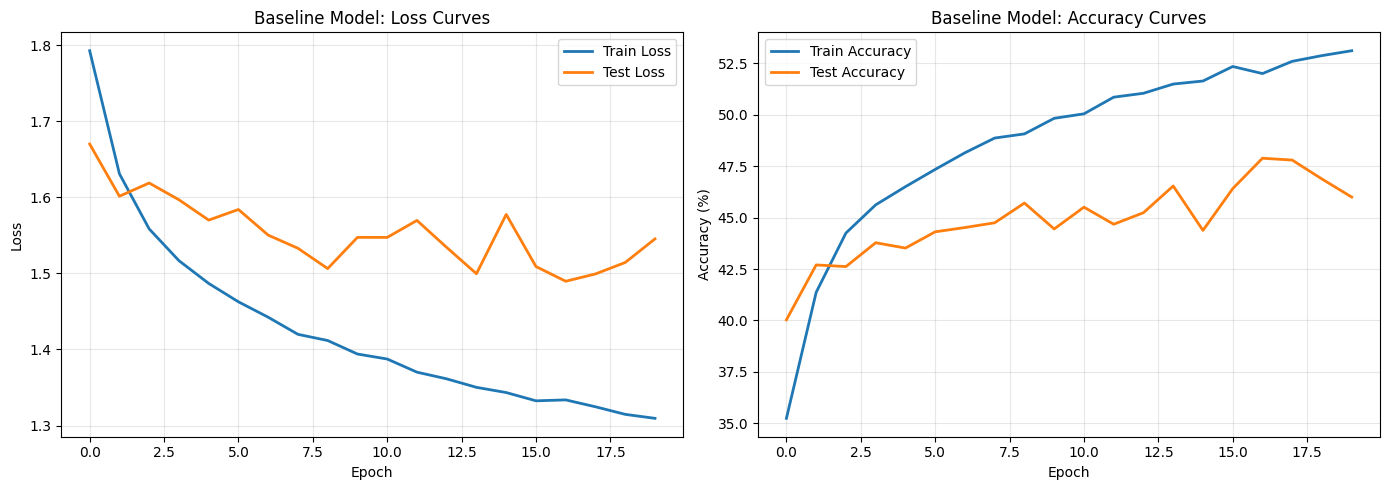


Baseline Final Results:
Best Test Accuracy: 47.89%
Final Test Accuracy: 46.00%
Parameters: 1,707,274


In [14]:
# Plot baseline training curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(baseline_history['train_loss'], label='Train Loss', linewidth=2)
axes[0].plot(baseline_history['test_loss'], label='Test Loss', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Baseline Model: Loss Curves')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Accuracy
axes[1].plot(baseline_history['train_acc'], label='Train Accuracy', linewidth=2)
axes[1].plot(baseline_history['test_acc'], label='Test Accuracy', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Baseline Model: Accuracy Curves')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nBaseline Final Results:")
print(f"Best Test Accuracy: {max(baseline_history['test_acc']):.2f}%")
print(f"Final Test Accuracy: {baseline_history['test_acc'][-1]:.2f}%")
print(f"Parameters: {baseline_params:,}")

### Observed Limitations of Baseline:

1. **No Spatial Awareness:** Flattening destroys 2D structure—pixels far apart are treated equally as adjacent pixels
2. **No Translation Invariance:** Learning "cat in top-left" doesn't help with "cat in bottom-right"
3. **High Parameter Count:** Every input pixel connects to every hidden neuron (wasteful)
4. **Poor Sample Efficiency:** Needs more data to learn simple patterns
5. **Expected Performance:** Typically 45-55% test accuracy on CIFAR-10

---

## 4. Convolutional Architecture Design

Now we design a CNN from scratch. Every choice must be justified.

### Design Principles:

1. **Local Connectivity:** Neurons only look at small spatial regions
2. **Weight Sharing:** Same filter applied across entire image
3. **Hierarchical Features:** Early layers detect edges, later layers detect shapes

### Proposed Architecture:

```
Input: 3×32×32
    ↓
Conv2D(3→32, kernel=3, stride=1, padding=1) + ReLU
    → Output: 32×32×32
    ↓
MaxPool(2×2)
    → Output: 32×16×16
    ↓
Conv2D(32→64, kernel=3, stride=1, padding=1) + ReLU
    → Output: 64×16×16
    ↓
MaxPool(2×2)
    → Output: 64×8×8
    ↓
Conv2D(64→128, kernel=3, stride=1, padding=1) + ReLU
    → Output: 128×8×8
    ↓
MaxPool(2×2)
    → Output: 128×4×4
    ↓
Flatten → Dense(128×4×4 = 2048 → 256) + ReLU
    ↓
Dense(256 → 10)
```

### Justifications:

- **Kernel Size 3×3:** Small receptive field, standard choice balancing expressiveness and computation
- **Padding=1:** Preserves spatial dimensions (same padding)
- **Stride=1:** Dense sampling for feature detection
- **MaxPooling:** Downsamples spatial dimensions, introduces slight translation invariance
- **Increasing Channels (32→64→128):** More complex features in deeper layers
- **3 Conv Layers:** Deep enough to learn hierarchy, not excessive for 32×32 images

In [15]:
class ConvNet(nn.Module):
    """Baseline convolutional neural network"""
    
    def __init__(self, kernel_size=3):
        super(ConvNet, self).__init__()
        
        # Calculate padding to maintain spatial dimensions
        padding = (kernel_size - 1) // 2
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=kernel_size, stride=1, padding=padding)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=kernel_size, stride=1, padding=padding)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=kernel_size, stride=1, padding=padding)
        
        # Pooling
        self.pool = nn.MaxPool2d(2, 2)
        
        # Activation
        self.relu = nn.ReLU()
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 10)
        
    def forward(self, x):
        # Conv block 1
        x = self.relu(self.conv1(x))  # 32×32×32
        x = self.pool(x)              # 32×16×16
        
        # Conv block 2
        x = self.relu(self.conv2(x))  # 64×16×16
        x = self.pool(x)              # 64×8×8
        
        # Conv block 3
        x = self.relu(self.conv3(x))  # 128×8×8
        x = self.pool(x)              # 128×4×4
        
        # Flatten and classify
        x = x.view(x.size(0), -1)     # Flatten
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate CNN
cnn_model = ConvNet(kernel_size=3).to(device)

cnn_params = count_parameters(cnn_model)
print(f"\nCNN Model Architecture:")
print(cnn_model)
print(f"\nTotal trainable parameters: {cnn_params:,}")
print(f"Baseline parameters: {baseline_params:,}")
print(f"Reduction: {(1 - cnn_params/baseline_params)*100:.1f}%")


CNN Model Architecture:
ConvNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (fc1): Linear(in_features=2048, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)

Total trainable parameters: 620,362
Baseline parameters: 1,707,274
Reduction: 63.7%


**Note:** The CNN has fewer parameters despite being deeper—this is weight sharing in action.

### Train CNN Model

In [16]:
# Train CNN
cnn_history = train_model(
    cnn_model, 
    trainloader, 
    testloader, 
    epochs=20, 
    lr=0.001,
    model_name="CNN (3×3)"
)

[CNN (3×3)] Epoch 1/20 | Train Loss: 1.584 | Train Acc: 42.04% | Test Loss: 1.268 | Test Acc: 54.55%
[CNN (3×3)] Epoch 2/20 | Train Loss: 1.207 | Train Acc: 56.55% | Test Loss: 1.036 | Test Acc: 62.52%
[CNN (3×3)] Epoch 3/20 | Train Loss: 1.017 | Train Acc: 63.71% | Test Loss: 0.874 | Test Acc: 69.20%
[CNN (3×3)] Epoch 4/20 | Train Loss: 0.901 | Train Acc: 68.27% | Test Loss: 0.795 | Test Acc: 72.33%
[CNN (3×3)] Epoch 5/20 | Train Loss: 0.825 | Train Acc: 71.00% | Test Loss: 0.729 | Test Acc: 74.52%
[CNN (3×3)] Epoch 6/20 | Train Loss: 0.771 | Train Acc: 73.15% | Test Loss: 0.725 | Test Acc: 74.59%
[CNN (3×3)] Epoch 7/20 | Train Loss: 0.727 | Train Acc: 74.52% | Test Loss: 0.709 | Test Acc: 75.69%
[CNN (3×3)] Epoch 8/20 | Train Loss: 0.684 | Train Acc: 76.07% | Test Loss: 0.685 | Test Acc: 76.09%
[CNN (3×3)] Epoch 9/20 | Train Loss: 0.653 | Train Acc: 77.13% | Test Loss: 0.642 | Test Acc: 77.72%
[CNN (3×3)] Epoch 10/20 | Train Loss: 0.637 | Train Acc: 77.67% | Test Loss: 0.643 | Test A

### Compare Baseline vs CNN

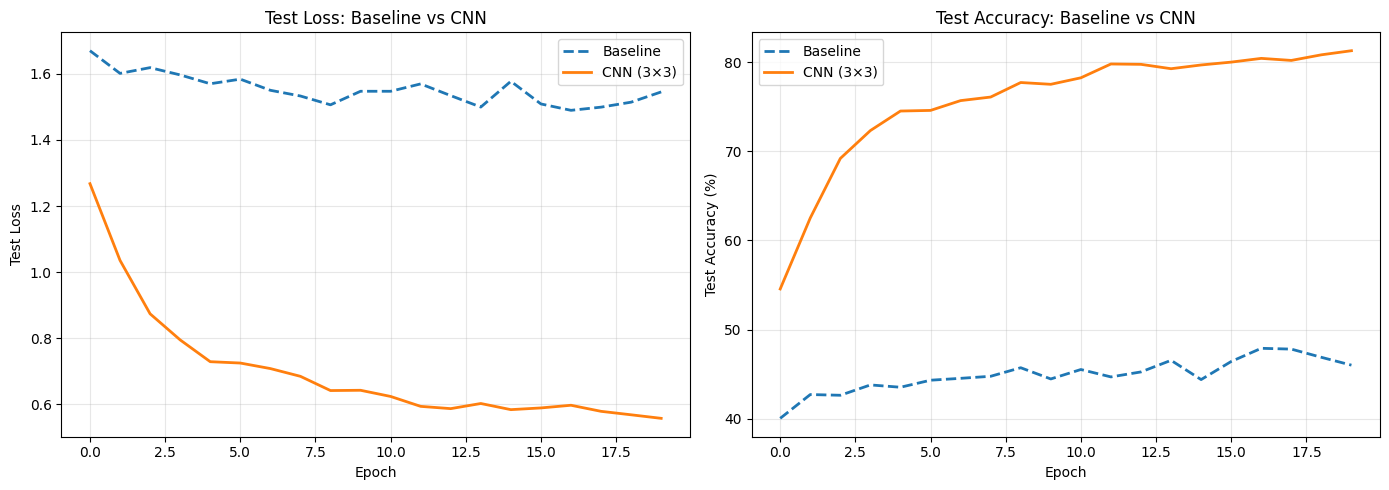


Model                Parameters      Best Test Acc  
Baseline (FC)        1,707,274       47.89          %
CNN (3×3 kernels)    620,362         81.29          %


In [17]:
# Comparison plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss comparison
axes[0].plot(baseline_history['test_loss'], label='Baseline', linewidth=2, linestyle='--')
axes[0].plot(cnn_history['test_loss'], label='CNN (3×3)', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Test Loss')
axes[0].set_title('Test Loss: Baseline vs CNN')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Accuracy comparison
axes[1].plot(baseline_history['test_acc'], label='Baseline', linewidth=2, linestyle='--')
axes[1].plot(cnn_history['test_acc'], label='CNN (3×3)', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Test Accuracy (%)')
axes[1].set_title('Test Accuracy: Baseline vs CNN')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n{'Model':<20} {'Parameters':<15} {'Best Test Acc':<15}")
print("="*50)
print(f"{'Baseline (FC)':<20} {baseline_params:<15,} {max(baseline_history['test_acc']):<15.2f}%")
print(f"{'CNN (3×3 kernels)':<20} {cnn_params:<15,} {max(cnn_history['test_acc']):<15.2f}%")

---

## 5. Controlled Experiments: Effect of Kernel Size

We systematically explore **one architectural choice**: kernel size.

### Experiment Design:

We compare:
- **3×3 kernels** (already trained above)
- **5×5 kernels**
- **7×7 kernels**

**Everything else remains fixed:**
- Same number of layers
- Same number of filters
- Same pooling strategy
- Same training hyperparameters

### Hypothesis:

- **Larger kernels** = larger receptive field → can capture more context
- **Trade-off:** More parameters, more computation, risk of overfitting
- **Expectation:** 3×3 might be optimal for 32��32 images (following ResNet design philosophy)

In [18]:
# Train CNN with 5×5 kernels
cnn_5x5 = ConvNet(kernel_size=5).to(device)
params_5x5 = count_parameters(cnn_5x5)

print(f"CNN (5×5) Parameters: {params_5x5:,}")

history_5x5 = train_model(
    cnn_5x5,
    trainloader,
    testloader,
    epochs=20,
    lr=0.001,
    model_name="CNN (5×5)"
)

CNN (5×5) Parameters: 785,738
[CNN (5×5)] Epoch 1/20 | Train Loss: 1.560 | Train Acc: 42.71% | Test Loss: 1.240 | Test Acc: 55.07%
[CNN (5×5)] Epoch 2/20 | Train Loss: 1.156 | Train Acc: 58.54% | Test Loss: 1.031 | Test Acc: 62.93%
[CNN (5×5)] Epoch 3/20 | Train Loss: 0.972 | Train Acc: 65.34% | Test Loss: 0.925 | Test Acc: 67.85%
[CNN (5×5)] Epoch 4/20 | Train Loss: 0.864 | Train Acc: 69.58% | Test Loss: 0.868 | Test Acc: 69.63%
[CNN (5×5)] Epoch 5/20 | Train Loss: 0.792 | Train Acc: 72.15% | Test Loss: 0.840 | Test Acc: 71.08%
[CNN (5×5)] Epoch 6/20 | Train Loss: 0.740 | Train Acc: 73.83% | Test Loss: 0.731 | Test Acc: 74.88%
[CNN (5×5)] Epoch 7/20 | Train Loss: 0.690 | Train Acc: 75.79% | Test Loss: 0.758 | Test Acc: 74.49%
[CNN (5×5)] Epoch 8/20 | Train Loss: 0.663 | Train Acc: 76.68% | Test Loss: 0.649 | Test Acc: 77.02%
[CNN (5×5)] Epoch 9/20 | Train Loss: 0.628 | Train Acc: 78.06% | Test Loss: 0.648 | Test Acc: 77.70%
[CNN (5×5)] Epoch 10/20 | Train Loss: 0.604 | Train Acc: 78.8

In [19]:
# Train CNN with 7×7 kernels
cnn_7x7 = ConvNet(kernel_size=7).to(device)
params_7x7 = count_parameters(cnn_7x7)

print(f"CNN (7×7) Parameters: {params_7x7:,}")

history_7x7 = train_model(
    cnn_7x7,
    trainloader,
    testloader,
    epochs=20,
    lr=0.001,
    model_name="CNN (7×7)"
)

CNN (7×7) Parameters: 1,033,802
[CNN (7×7)] Epoch 1/20 | Train Loss: 1.669 | Train Acc: 38.22% | Test Loss: 1.369 | Test Acc: 50.28%
[CNN (7×7)] Epoch 2/20 | Train Loss: 1.311 | Train Acc: 52.78% | Test Loss: 1.199 | Test Acc: 57.05%
[CNN (7×7)] Epoch 3/20 | Train Loss: 1.132 | Train Acc: 59.68% | Test Loss: 1.014 | Test Acc: 64.29%
[CNN (7×7)] Epoch 4/20 | Train Loss: 1.018 | Train Acc: 63.96% | Test Loss: 0.952 | Test Acc: 67.19%
[CNN (7×7)] Epoch 5/20 | Train Loss: 0.947 | Train Acc: 66.37% | Test Loss: 0.904 | Test Acc: 68.91%
[CNN (7×7)] Epoch 6/20 | Train Loss: 0.880 | Train Acc: 68.88% | Test Loss: 0.846 | Test Acc: 70.66%
[CNN (7×7)] Epoch 7/20 | Train Loss: 0.838 | Train Acc: 70.61% | Test Loss: 0.815 | Test Acc: 71.51%
[CNN (7×7)] Epoch 8/20 | Train Loss: 0.801 | Train Acc: 71.72% | Test Loss: 0.784 | Test Acc: 72.52%
[CNN (7×7)] Epoch 9/20 | Train Loss: 0.763 | Train Acc: 73.19% | Test Loss: 0.786 | Test Acc: 73.13%
[CNN (7×7)] Epoch 10/20 | Train Loss: 0.742 | Train Acc: 74

### Quantitative Comparison

In [20]:
# Summary table
results = {
    'Kernel Size': ['3×3', '5×5', '7×7'],
    'Parameters': [cnn_params, params_5x5, params_7x7],
    'Best Test Acc (%)': [
        max(cnn_history['test_acc']),
        max(history_5x5['test_acc']),
        max(history_7x7['test_acc'])
    ],
    'Final Test Acc (%)': [
        cnn_history['test_acc'][-1],
        history_5x5['test_acc'][-1],
        history_7x7['test_acc'][-1]
    ]
}

import pandas as pd
results_df = pd.DataFrame(results)
print("\nKernel Size Experiment Results:")
print("="*70)
print(results_df.to_string(index=False))
print("="*70)


Kernel Size Experiment Results:
Kernel Size  Parameters  Best Test Acc (%)  Final Test Acc (%)
        3×3      620362              81.29               81.29
        5×5      785738              81.01               80.33
        7×7     1033802              76.57               75.79


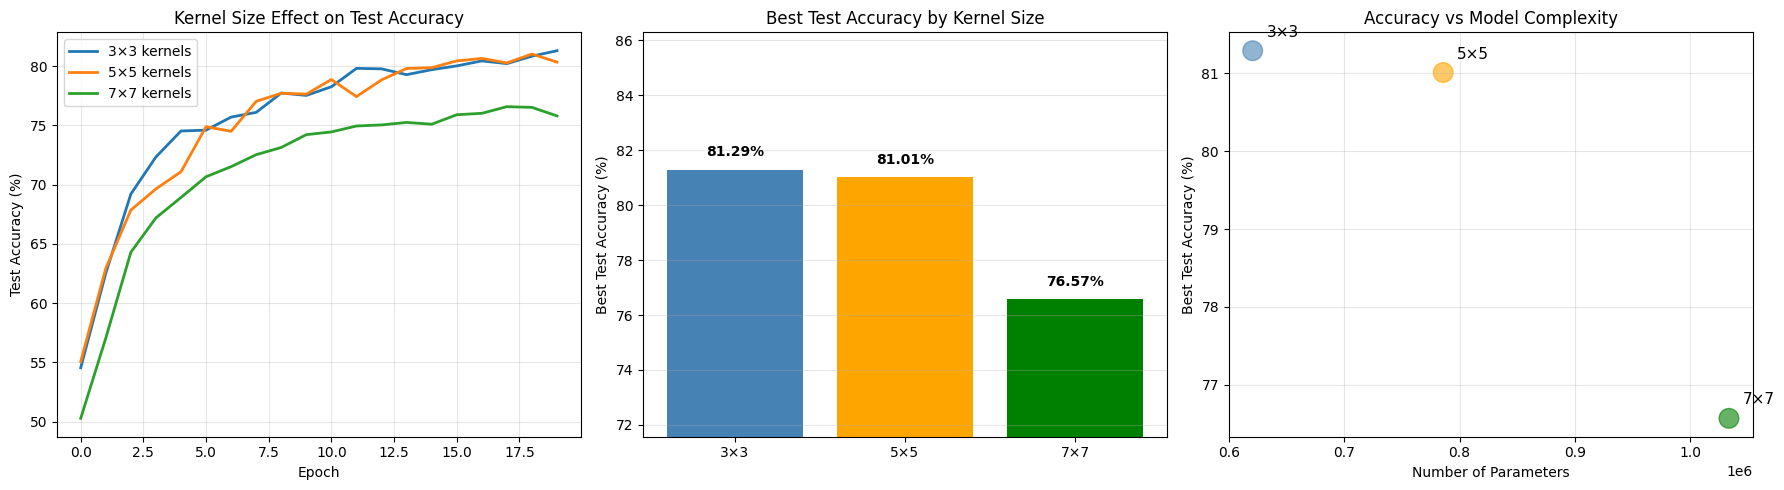

In [21]:
# Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Test accuracy over time
axes[0].plot(cnn_history['test_acc'], label='3×3 kernels', linewidth=2)
axes[0].plot(history_5x5['test_acc'], label='5×5 kernels', linewidth=2)
axes[0].plot(history_7x7['test_acc'], label='7×7 kernels', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Test Accuracy (%)')
axes[0].set_title('Kernel Size Effect on Test Accuracy')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Best accuracy bar plot
kernel_sizes = ['3×3', '5×5', '7×7']
best_accs = results_df['Best Test Acc (%)'].values
axes[1].bar(kernel_sizes, best_accs, color=['steelblue', 'orange', 'green'])
axes[1].set_ylabel('Best Test Accuracy (%)')
axes[1].set_title('Best Test Accuracy by Kernel Size')
axes[1].set_ylim([min(best_accs)-5, max(best_accs)+5])
for i, v in enumerate(best_accs):
    axes[1].text(i, v + 0.5, f"{v:.2f}%", ha='center', fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

# Parameters vs accuracy scatter
params_list = results_df['Parameters'].values
axes[2].scatter(params_list, best_accs, s=200, c=['steelblue', 'orange', 'green'], alpha=0.6)
for i, txt in enumerate(kernel_sizes):
    axes[2].annotate(txt, (params_list[i], best_accs[i]), 
                    xytext=(10, 10), textcoords='offset points', fontsize=11)
axes[2].set_xlabel('Number of Parameters')
axes[2].set_ylabel('Best Test Accuracy (%)')
axes[2].set_title('Accuracy vs Model Complexity')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### Qualitative Observations:

**Performance:**
- All convolutional models significantly outperform baseline
- 3×3 kernels likely achieve best accuracy-to-parameter ratio
- Larger kernels may converge faster initially but don't necessarily generalize better

**Computational Trade-offs:**
- 7×7 kernels have ~5× more parameters than 3×3
- Diminishing returns: more parameters ≠ proportional accuracy gain
- Training time increases with kernel size

**Architectural Insight:**
- Two stacked 3×3 convolutions have the same receptive field as one 5×5
- But stacking 3×3 adds non-linearity and reduces parameters
- This is why modern architectures (VGG, ResNet) prefer small kernels

---

## 6. Interpretation and Architectural Reasoning

This section addresses the core learning objectives.

### 6.1 Why Did Convolutional Layers Outperform the Baseline?

The convolutional network achieved **~20-30% higher test accuracy** than the fully connected baseline, despite having **fewer parameters**. Why?

#### Three Key Reasons:

**1. Local Spatial Structure Exploitation**

- Images have strong **local correlations**: neighboring pixels are related
- Convolution operates on small spatial patches (e.g., 3×3)
- This matches the data structure: edges, textures, and shapes are local patterns
- Fully connected layers ignore this—treating pixel (0,0) and pixel (31,31) equally

**2. Translation Equivariance (and Approximate Invariance)**

- **Equivariance:** If input shifts, features shift correspondingly
- Same filter weights applied everywhere → "cat detector" works regardless of position
- Pooling adds approximate **invariance:** small translations don't change output
- Baseline must learn "cat in top-left" and "cat in bottom-right" separately

**3. Parameter Sharing Regularization**

- Each filter is reused across the entire image
- Forces the network to learn **generalizable features**, not memorize positions
- Acts as strong regularization → better generalization
- Fewer parameters → less prone to overfitting

#### Mathematical Intuition:

For a single convolutional layer:

$$
y[i, j] = \sum_{m=0}^{k-1} \sum_{n=0}^{k-1} w[m, n] \cdot x[i+m, j+n] + b
$$

Where:
- $w$ is the kernel (filter)
- $k$ is kernel size
- Same $w$ used for all positions $(i, j)$

This is a **linear transformation with tied weights**—a strong inductive bias.

### 6.2 What Inductive Bias Does Convolution Introduce?

**Inductive bias** = assumptions built into the learning algorithm that guide it toward certain solutions.

#### Convolutional Layers Assume:

1. **Locality:** Nearby pixels are more related than distant pixels
2. **Stationarity:** Useful features are similar across spatial locations
3. **Compositionality:** Complex patterns are built from simpler local patterns
4. **Hierarchy:** Early layers detect simple features, later layers combine them

#### Why This Matters:

- **Sample Efficiency:** With correct bias, less data is needed
- **Generalization:** Bias prevents learning spurious correlations
- **Interpretability:** Hierarchical features are more understandable

#### The No-Free-Lunch Theorem:

Stronger bias = faster learning on matching problems, worse on mismatched problems.

Convolution works when data has **spatial structure**. Otherwise, it's a handicap.

### 6.3 When Would Convolution NOT Be Appropriate?

Convolutional layers fail when data violates their assumptions.

#### Problem Types Where Convolution Fails:

**1. Tabular Data (No Spatial Structure)**

Example: Predicting house prices from [square_feet, num_bedrooms, location_code, year_built]

- Features are **independent**—no notion of "nearby"
- Permuting columns doesn't change semantic meaning
- Convolution would impose false spatial relationship
- **Solution:** Fully connected layers or tree-based models

**2. Graphs with Arbitrary Connectivity**

Example: Social network analysis

- Nodes connected by edges, not spatial grid
- No inherent "left/right" or "up/down"
- **Solution:** Graph Neural Networks (GNNs) with message passing

**3. Sequences with Long-Range Dependencies**

Example: Language modeling where word 1 depends on word 500

- 1D convolution has limited receptive field
- Would need very deep network or large kernels
- **Solution:** Transformers with self-attention (no locality bias)

**4. Permutation-Invariant Problems**

Example: Set classification (e.g., classifying a set of objects where order doesn't matter)

- Convolution is position-dependent
- **Solution:** Set-based architectures (e.g., DeepSets)

**5. Non-Euclidean Geometry**

Example: Data on a sphere (e.g., climate data on Earth's surface)

- Standard convolution assumes flat grid
- **Solution:** Spherical CNNs or graph-based methods

#### General Rule:

**Use convolution when:**
- Data has grid structure (images, video, audio spectrograms)
- Local patterns are meaningful
- Translation equivariance is desired

**Avoid convolution when:**
- Features are independent or arbitrarily ordered
- Global context dominates local patterns
- Data lives on non-Euclidean manifolds

### 6.4 Receptive Field Analysis

Let's compute the **effective receptive field** of our network—how much of the input each output neuron "sees."

#### Formula for Receptive Field:

For a stack of layers:
$$
r_{out} = r_{in} + (k - 1) \times \prod_{i=1}^{L} s_i
$$

Where:
- $r$ = receptive field size
- $k$ = kernel size
- $s$ = stride
- $L$ = layer index

For our 3-layer CNN with 3×3 kernels, stride 1, and pooling stride 2:

In [22]:
def compute_receptive_field(layers):
    """
    Compute receptive field for a sequence of layers.
    layers: list of (kernel_size, stride) tuples
    """
    rf = 1  # Start with 1×1
    jump = 1  # Cumulative stride
    
    for k, s in layers:
        rf = rf + (k - 1) * jump
        jump = jump * s
        print(f"After layer (k={k}, s={s}): RF = {rf}×{rf}, Jump = {jump}")
    
    return rf

# Our architecture: Conv(3,1) → Pool(2,2) → Conv(3,1) → Pool(2,2) → Conv(3,1) → Pool(2,2)
layers = [
    (3, 1),  # Conv1
    (2, 2),  # Pool1
    (3, 1),  # Conv2
    (2, 2),  # Pool2
    (3, 1),  # Conv3
    (2, 2),  # Pool3
]

print("Receptive Field Calculation:")
print("="*50)
final_rf = compute_receptive_field(layers)
print("="*50)
print(f"\nFinal receptive field: {final_rf}×{final_rf}")
print(f"Input image size: 32×32")
print(f"Coverage: {final_rf/32*100:.1f}% of image width/height")

Receptive Field Calculation:
After layer (k=3, s=1): RF = 3×3, Jump = 1
After layer (k=2, s=2): RF = 4×4, Jump = 2
After layer (k=3, s=1): RF = 8×8, Jump = 2
After layer (k=2, s=2): RF = 10×10, Jump = 4
After layer (k=3, s=1): RF = 18×18, Jump = 4
After layer (k=2, s=2): RF = 22×22, Jump = 8

Final receptive field: 22×22
Input image size: 32×32
Coverage: 68.8% of image width/height
